In [1]:
# useful modules
import matplotlib.pyplot as plt
import os
import numpy as np

# allows us to access the modules directory in the repository
import sys
sys.path.append('../functions/')

# just my personal preferences for plotting in Jupyter
plt.rcParams['font.size'] = '16'
plt.rcParams['figure.figsize'] = [7, 5]
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
  display: table-cell;
  text-align: center;
  vertical-align: middle;
}
</style>
""")

# Quickstart Tutorial: Using the transformed payoffs to investigate coordination in a threshold game

The purpose of this tutorial is to show how homophilic dynamics can be investiged via the dynamics in a well-mixed population with transformed payoffs. The results in this tutorial match the results in another tutorial: "Coordination in a threshold game". The transformed payoffs method described here is often faster to use when the group size is small.

## 1. Specify the scenario and payoff function

We specify the same scenario as used in the "Coordination in threshold game" tutorial.

We consider 4 strategies: Unconditional Cooperators (U), Unconditional Defectors (D), Coordinating Cooperators (C), and Liars (L). We specify a cognitive cost to coordination $-0.1$, threshold $\tau \geq 5$., cost of contributing to the public good $-1$, and benefit produced by the public good when the threshold is met $3$.

In [2]:
game_pars = {
        'strat_names': ['D', 'C', 'L', 'U'],
        'cognitive_cost': -0.1, # a small cost to understanding coordination
        'tau': 5,               # lottery quorum and midpoint of benefits function minus 0.5
        'contrib_cost': -1,     # cost of contributing to public good
        'benefit_thresh_met': 3 # benefit when threshold is met
        }

We model groups with 8 individuals that form according to the 'members recruit' group-formation model. The members recruit nonkin with probability $q$ and kin with probability $1-q$ (i.e., homophily $h = 1-q$). We will choose $q=0.5$ (will be changed to $q=0.8$ below).

In [3]:
evol_pars = {
        'n': 8,                                     # group size
        'n_s': 4,                                   # number of strategies
        'group_formation_model': 'members recruit', # group formation model
        'q': 0.5,                                   # parameter for leader-driven model
        'sumprodm_dir': os.path.abspath('../members_recruit_comb_term/'),
        'partn2prob_dir': os.path.abspath('../results/partn2prob/'),
        }

The steps above are the same as in the other tutorial, but we specify the model and payoffs differently.

To specify the model, we will make use of the abstract base class `TransmatBase` in `functions/transmat_base.py`.

In [4]:
from transmat_base import TransmatBase

 `TransmatBase` has an abstract method called `calc_payoff()`, which accepts a group's strategy distribution and returns the payoff to the focal strategy.

```
Inputs:
---

focal_strat, int
    The strategy played by the focal player, where the value correspond to index of strat_names

strat_counts, list of ints
    Whole-group distribution of strategies, including the focal, in the same order as strat_names

Outputs:
---

payoff_total, float
    Payoff to the focal strategist given the whole-group distribution
   
```

We will create a class `ThresholdUDCL` that inherits the `TransmatBase` class and implements the `calc_payoff()` method corresponding to a threshold game.

In [5]:
import numpy as np
from scipy.special import binom

class ThresholdUDCL(TransmatBase):

    def __init__(self, *args, **kwargs):

        # inherit everything
        super(self.__class__, self).__init__(*args, **kwargs)

        # we now have names for the strategies
        self.strat_names = self.game_pars['strat_names']
        assert(len(self.strat_names) == self.n_s)    # check size matches what expecting


    def __str__(self):

        s = super().__str__()
        s += 'Game played: A threshold game with the option of a lottery/straw-drawing mechanic.\n'

        return s


    def calc_payoff(self, focal_strat_idx, strat_counts):

        # parameters to set up game
        # ---

        n = self.n                      # group size
        tau = self.game_pars['tau']     # both quorum and threshold
        cognitive_cost = self.game_pars['cognitive_cost']
        contrib_cost = self.game_pars['contrib_cost']
        benefit_thresh_met = self.game_pars['benefit_thresh_met']
        focal_strat = self.game_pars['strat_names'][focal_strat_idx]

        # count strategies in group
        countD, countC, countL, countU = strat_counts
        
        # payoff calculation depends on whether or not the lottery quorum is met
        # ---

        if countC + countL < tau: # if the lottery quorum is not met

            k = countU                                      # only U will contribute
            benefit = benefit_thresh_met if k >= tau else 0 # benefit from PGG

            # payoff returned depends on the focal strategy
            
            if focal_strat == 'U':

                payoff_total = benefit + contrib_cost

            elif focal_strat == 'D':

                payoff_total = benefit

            else: # focal_strat == C or L

                payoff_total = benefit + cognitive_cost

        else: # if the lottery quorum is met

            # probability that j Coordinating Cooperators (in contrast to Liars)
            # will be designated as contributors by the lottery
            
            denom = binom(countC + countL, tau)
            PjV = [binom(countC, j)*binom(countL, tau-j)/denom for j in range(0, tau+1)]

            # the benefit returned for each j
            benefitjV = [benefit_thresh_met if j+countU >= tau else 0 for j in range(0, tau+1)]

            # payoff returned depends on the focal strategy
            
            if focal_strat == 'U':

                payoff_total = sum(Pj*benefitj for Pj, benefitj in zip(PjV, benefitjV)) + contrib_cost

            elif focal_strat == 'D':

                payoff_total = sum(Pj*benefitj for Pj, benefitj in zip(PjV, benefitjV))

            elif focal_strat == 'C':

                payoff_total = sum(PjV[j]*(benefitjV[j] + contrib_cost*j/countC) for j in range(0, tau+1)) + cognitive_cost

            else: # focal_strat == 'L':

                payoff_total = sum(Pj*benefitj for Pj, benefitj in zip(PjV, benefitjV)) + cognitive_cost


        return payoff_total


## 2. Initialise the model

We can now initialise the model by instantiating the `ThresholdUDCL` class, which incorporates the `calc_payoff()` method above and calculates the necessary outputs from the group-formation model (e.g., partition-structure probabilities $F$), but also calculates the untransformed and transformed payoff matrices.

In [6]:
# this will take about 10 seconds

thresholdUDCL = ThresholdUDCL(evol_pars, game_pars)

For example, `thresholdUDCL` now contains the transformed payoff matrix $B$, which is an 8-dimensional matrix.

In [7]:
thresholdUDCL.B.shape

(4, 4, 4, 4, 4, 4, 4, 4)

In contrast to the method in the other tutorial, the homophily parameter $q$ and $F$ values cannot be quickly updated with a function like `update_F()`. Each time the homophily level is changed, the whole $B$ matrix must be recalculated.

In [8]:
thresholdUDCL.evol_pars['q'] = 0.8
thresholdUDCL.update_F_and_B() # takes another ~6 seconds

## 3. Explore the dynamics

### 3.1 Explore dynamics on the faces of the tetrahedral strategy space

The `tetraplot4class` module contains specialised plotting functions when $m=4$. We can use it to plot the dynamics on the faces of the tetrahedral strategy space (on the "net").

In [9]:
import tetraplot4class as tp

This will take about a few seconds ...


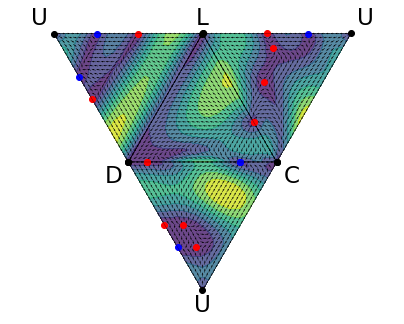

In [10]:
# create the plot axis object
ax = plt.figure().add_subplot(1,1,1)

# define the corners of the triangles in the net plot
tris = tp.net_plot_initialise(ax, thresholdUDCL.strat_names)

# get a list of barycentric grid points for each face of the tetrahedron
lV = tp.net_get_face_mesh(2**5)        # fine mesh
lV_coarse = tp.net_get_face_mesh(2**3) # coarse mesh


# get dynamics

print('This will take about a few seconds ...')

# find fixed points using coarse grid as start points
fp_baryV = tp.net_find_fixed_points(lV_coarse, thresholdUDCL.deltap_fnc)

 # find gradient of selection at each point on fine grid
strengthsV, dirn_normV = tp.net_calc_grad_on_mesh(tris, lV, thresholdUDCL.deltap_fnc)


# plot dynamics

# rate of change (colour contour)
tp.net_plot_dynamics_rate(ax, tris, lV, strengthsV)

# direction of selection (arrows)
tp.net_plot_dynamics_dirn(ax, tris, lV, dirn_normV)     

# fixed points with colours indicating their stability
tp.net_plot_fixed_points_w_stability(ax, tris, fp_baryV, thresholdUDCL.calc_stability)

plt.show()

This figure matches the figure found in the `Coordination threshold game` tutorial using the functions from `model_base.py`.